In [751]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pylab import rcParams
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')

# data

In [752]:
data_owid = pd.read_csv("./dataset/owid-energy-data.csv")

In [753]:
data_owid

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.87,1.550,NaN,569.557,NaN,NaN,NaN,NaN,NaN,76.03,NaN,NaN,NaN,NaN,20.081,NaN,378.61,NaN,378.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.36,NaN,NaN,80.653,NaN,NaN,NaN,NaN,NaN,164.26,NaN,NaN,NaN,NaN,NaN,43.385,NaN,215.64,NaN,NaN,NaN,NaN,50.45,NaN,13.325,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,65.07,NaN,NaN,NaN,NaN,NaN,17.187,NaN,NaN,22.80,16.93,NaN,NaN,NaN,NaN,NaN,6.022,4.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.46,1.596,NaN,567.642,NaN,NaN,NaN,NaN,NaN,86.26,NaN,NaN,NaN,NaN,21.307,NaN,404.85,NaN,404.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.66,NaN,NaN,80.934,NaN,NaN,NaN,NaN,NaN,190.41,NaN,NaN,NaN,NaN,NaN,47.032,NaN,229.81,NaN,NaN,NaN,NaN,54.33,NaN,13.420,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,50.99,NaN,NaN,NaN,NaN,NaN,12.595,NaN,NaN,22.86,16.40,NaN,NaN,NaN,NaN,NaN,5.647,4.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN

## historical data for EDA

In [754]:
cpi = pd.read_csv('./dataset/consumer-price-index.csv')

In [755]:
cpi

,Entity,Code,Year,Consumer price index (2010 = 100)
0,Italy,ITA,1960,4.147836
1,Italy,ITA,1961,4.232895
2,Italy,ITA,1962,4.431467
3,Italy,ITA,1963,4.761820
4,Italy,ITA,1964,5.043354
...,...,...,...,...
59,Italy,ITA,2019,110.623600
60,Italy,ITA,2020,110.471260
61,Italy,ITA,2021,112.541250
62,Italy,ITA,2022,121.771090


In [756]:
cpi = cpi[['Year','Consumer price index (2010 = 100)']].reset_index(drop=True)

In [757]:
cpi['Year'] = pd.to_datetime(cpi['Year'],format='%Y')

In [758]:
cpi = cpi.rename(columns={'Consumer price index (2010 = 100)':'cpi','Year':'year'})

In [759]:
cpi = cpi.set_index('year').dropna()

In [760]:
cpi

,cpi
year,
1960-01-01,4.147836
1961-01-01,4.232895
1962-01-01,4.431467
1963-01-01,4.761820
1964-01-01,5.043354
...,...
2019-01-01,110.623600
2020-01-01,110.471260
2021-01-01,112.541250


In [761]:
co2 = pd.read_csv('./dataset/annual-co2-emissions-per-country.csv')

In [762]:
co2

,Entity,Code,Year,Annual CO₂ emissions
0,Italy,ITA,1860,29312.0
1,Italy,ITA,1861,670512.0
2,Italy,ITA,1862,1227440.0
3,Italy,ITA,1863,1069888.0
4,Italy,ITA,1864,1604832.0
...,...,...,...,...
159,Italy,ITA,2019,339633540.0
160,Italy,ITA,2020,302602430.0
161,Italy,ITA,2021,335977820.0
162,Italy,ITA,2022,340672300.0


In [763]:
co2 = co2[['Year','Annual CO₂ emissions']].reset_index(drop=True)

In [764]:
co2['Year'] = pd.to_datetime(co2['Year'],format='%Y')

In [765]:
co2 = co2.rename(columns={'Annual CO₂ emissions':'co2','Year':'year'})

In [766]:
co2 = co2.set_index('year').dropna()

In [767]:
co2

,co2
year,
1860-01-01,29312.0
1861-01-01,670512.0
1862-01-01,1227440.0
1863-01-01,1069888.0
1864-01-01,1604832.0
...,...
2019-01-01,339633540.0
2020-01-01,302602430.0
2021-01-01,335977820.0


In [768]:
density = pd.read_csv('./dataset/population-density.csv')

In [769]:
density

,Entity,Code,Year,Population density
0,Italy,ITA,1400,27.066790
1,Italy,ITA,1500,30.448635
2,Italy,ITA,1600,44.898500
3,Italy,ITA,1700,45.602116
4,Italy,ITA,1710,47.004980
...,...,...,...,...
309,Italy,ITA,2096,122.844600
310,Italy,ITA,2097,122.036360
311,Italy,ITA,2098,121.236260
312,Italy,ITA,2099,120.438385


In [770]:
density = density[['Year','Population density']].loc[density['Year'] >= 1931].reset_index(drop=True)

In [771]:
density['Year'] = pd.to_datetime(density['Year'],format='%Y')

In [772]:
density = density.rename(columns={'Population density':'density','Year':'year'})

In [773]:
density = density.set_index('year').dropna()

In [774]:
density

,density
year,
1931-01-01,136.959120
1932-01-01,138.116010
1933-01-01,139.273390
1934-01-01,140.440480
1935-01-01,141.617320
...,...
2096-01-01,122.844600
2097-01-01,122.036360
2098-01-01,121.236260


In [775]:
precipitation = pd.read_csv('./dataset/average-precipitation-per-year.csv')

In [776]:
precipitation

,Entity,Code,Year,Annual precipitation
0,Italy,ITA,1931,980.4897
1,Italy,ITA,1932,876.2479
2,Italy,ITA,1933,986.2547
3,Italy,ITA,1934,874.7829
4,Italy,ITA,1935,987.7974
...,...,...,...,...
89,Italy,ITA,2020,981.3541
90,Italy,ITA,2021,990.3465
91,Italy,ITA,2022,818.1664
92,Italy,ITA,2023,1025.3726


In [777]:
precipitation = precipitation[['Year','Annual precipitation']].reset_index(drop=True)

In [778]:
precipitation['Year'] = pd.to_datetime(precipitation['Year'],format='%Y')

In [779]:
precipitation = precipitation.rename(columns={'Annual precipitation':'precipitation','Year':'year'})

In [780]:
precipitation = precipitation.set_index('year').dropna()

In [781]:
precipitation

,precipitation
year,
1931-01-01,980.4897
1932-01-01,876.2479
1933-01-01,986.2547
1934-01-01,874.7829
1935-01-01,987.7974
...,...
2020-01-01,981.3541
2021-01-01,990.3465
2022-01-01,818.1664


In [782]:
temperature = pd.read_csv('./dataset/annual-temperature-anomalies.csv')

In [783]:
temperature

,Entity,Code,Year,Temperature anomaly
0,Italy,ITA,1931,-2.784570
1,Italy,ITA,1932,-2.762485
2,Italy,ITA,1933,-2.598746
3,Italy,ITA,1934,-2.625348
4,Italy,ITA,1935,-2.685322
...,...,...,...,...
89,Italy,ITA,2020,0.610705
90,Italy,ITA,2021,0.337167
91,Italy,ITA,2022,1.275581
92,Italy,ITA,2023,1.230895


In [784]:
temperature = temperature[['Year','Temperature anomaly']].reset_index(drop=True)

In [785]:
temperature['Year'] = pd.to_datetime(temperature['Year'],format='%Y')

In [786]:
temperature = temperature.rename(columns={'Temperature anomaly':'temperature_anomaly','Year':'year'})

In [787]:
temperature = temperature.set_index('year').dropna()

In [788]:
temperature

,temperature_anomaly
year,
1931-01-01,-2.784570
1932-01-01,-2.762485
1933-01-01,-2.598746
1934-01-01,-2.625348
1935-01-01,-2.685322
...,...
2020-01-01,0.610705
2021-01-01,0.337167
2022-01-01,1.275581


In [789]:
historical_data = data_owid.loc[(data_owid['year'] > 1930) & (data_owid['year'] < 2015) & (data_owid['country'] == 'Italy')]

In [790]:
historical_data

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
9980,Italy,1931,ITA,40501139.0,1.866570e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.549,-0.479,69.411,2.811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,0.093,4.594,0.186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,Italy,1932,ITA,40843255.0,1.906655e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.543,0.184,73.333,2.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.750,0.128,7.688,0.314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,Italy,1933,ITA,41185511.0,1.884730e+11,N

In [791]:
data = pd.read_csv("./dataset/energy.csv") # produzione lorda e consumo di energia elettrica in Italia - Anni 1883-2014 (milioni di kWh)

In [792]:
data

,year,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses
0,1931,"10,470","8,335",103,"6,213",803,209,"1,007",0
1,1932,"10,590","8,420",103,"6,223",845,225,"1,024",0
2,1933,"11,650","9,293",114,"6,984",860,243,"1,092",0
3,1934,"12,600","10,159",110,"7,684",879,258,"1,228",0
4,1935,"13,800","11,168",138,"8,583","1,003",267,"1,177",0
...,...,...,...,...,...,...,...,...,...
79,2010,"302,062","309,885","5,610","138,439","10,666","6,366","79,253","69,551"
80,2011,"302,570","313,792","5,907","140,040","10,720","6,202","80,783","70,140"
81,2012,"299,275","307,220","5,923","130,801","10,759","6,261","84,019","69,457"
82,2013,"289,803","297,288","5,677","124,871","10,774","5,977","83,005","66,983"


In [793]:
historical_data = historical_data.reset_index(drop=True)

In [794]:
data = data.reset_index(drop=True)

In [795]:
data['population'] = historical_data['population']

In [796]:
data['gdp'] = historical_data['gdp']

In [797]:
data.tail()

,year,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,population,gdp
79,2010,"302,062","309,885","5,610","138,439","10,666","6,366","79,253","69,551",59822452.0,2.080546e+12
80,2011,"302,570","313,792","5,907","140,040","10,720","6,202","80,783","70,140",60025952.0,2.110883e+12
81,2012,"299,275","307,220","5,923","130,801","10,759","6,261","84,019","69,457",60190152.0,2.047960e+12
82,2013,"289,803","297,288","5,677","124,871","10,774","5,977","83,005","66,983",60312600.0,2.010255e+12
83,2014,"279,829","291,084","5,372","122,505","10,462","5,885","82,604","64,255",60322792.0,2.010164e+12


In [798]:
data['per_capita_gdp'] = data['gdp'] / data['population'] 

In [799]:
data['year'] = pd.to_datetime(data['year'],format='%Y')

In [800]:
data.set_index('year',inplace=True)

In [801]:
data = data.merge(co2,left_index=True,right_index=True,how='left')

In [802]:
data = data.merge(density,left_index=True,right_index=True,how='left')

In [803]:
data = data.merge(precipitation,left_index=True,right_index=True,how='left')

In [804]:
data = data.merge(temperature,left_index=True,right_index=True,how='left')

In [805]:
data['per_capita_co2'] = data['co2'] / data['population'] 

In [806]:
for col in data.columns:
    if data[col].dtype == 'O':  
        data[col] = data[col].str.replace(',', '', regex=False)
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [807]:
data

,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,population,gdp,per_capita_gdp,co2,density,precipitation,temperature_anomaly,per_capita_co2
year,,,,,,,,,,,,,,,,
1931-01-01,10470,8335,103,6213,803,209,1007,0,40501139.0,1.866570e+11,4608.685542,34172700.0,136.95912,980.48970,-2.784570,0.843747
1932-01-01,10590,8420,103,6223,845,225,1024,0,40843255.0,1.906655e+11,4668.223864,28064604.0,138.11601,876.24790,-2.762485,0.687129
1933-01-01,11650,9293,114,6984,860,243,1092,0,41185511.0,1.884730e+11,4576.197903,30473790.0,139.27339,986.25470,-2.598746,0.739915
1934-01-01,12600,10159,110,7684,879,258,1228,0,41530635.0,1.879873e+11,4526.474142,39660990.0,140.44048,874.78290,-2.625348,0.954982
1935-01-01,13800,11168,138,8583,1003,267,1177,0,41878651.0,1.981434e+11,4731.370802,45376240.0,141.61732,987.79740,-2.685322,1.083517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,302062,309885,5610,138439,10666,6366,79253,69551,59822452.0,2.080546e+12,34778.680821,435710340.0,203.45181,1322.84860,-0.527131,7.283392
2011-01-01,302570,313792,5907,140040,10720,6202,80783,70140,60025952.0,2.110883e+12,35166.178870,423894300.0,204.14055,878.00850,0.283001,7.061851
2012-01-01,299275,307220,5923,130801,10759,6261,84019,69457,60190152.0,2.047960e+12,34024.833364,403441340.0,204.69395,1010.26935,0.307669,6.702780


In [808]:
data.drop(['gdp','population','co2'],axis=1,inplace=True)

In [809]:
data

,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,per_capita_gdp,density,precipitation,temperature_anomaly,per_capita_co2
year,,,,,,,,,,,,,
1931-01-01,10470,8335,103,6213,803,209,1007,0,4608.685542,136.95912,980.48970,-2.784570,0.843747
1932-01-01,10590,8420,103,6223,845,225,1024,0,4668.223864,138.11601,876.24790,-2.762485,0.687129
1933-01-01,11650,9293,114,6984,860,243,1092,0,4576.197903,139.27339,986.25470,-2.598746,0.739915
1934-01-01,12600,10159,110,7684,879,258,1228,0,4526.474142,140.44048,874.78290,-2.625348,0.954982
1935-01-01,13800,11168,138,8583,1003,267,1177,0,4731.370802,141.61732,987.79740,-2.685322,1.083517
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,302062,309885,5610,138439,10666,6366,79253,69551,34778.680821,203.45181,1322.84860,-0.527131,7.283392
2011-01-01,302570,313792,5907,140040,10720,6202,80783,70140,35166.178870,204.14055,878.00850,0.283001,7.061851
2012-01-01,299275,307220,5923,130801,10759,6261,84019,69457,34024.833364,204.69395,1010.26935,0.307669,6.702780


<Axes: xlabel='year'>

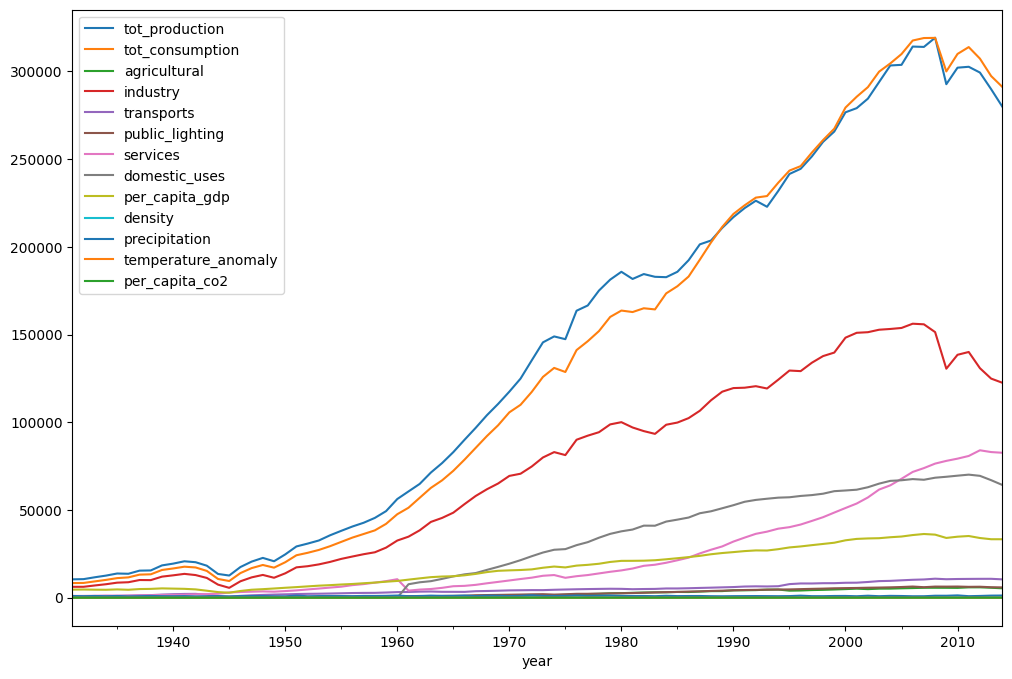

In [810]:
data.plot(figsize=(12,8))

In [811]:
data.columns

Index(['tot_production', 'tot_consumption', 'agricultural', 'industry',
       'transports', 'public_lighting', 'services', 'domestic_uses',
       'per_capita_gdp', 'density', 'precipitation', 'temperature_anomaly',
       'per_capita_co2'],
      dtype='object')

<Axes: xlabel='year'>

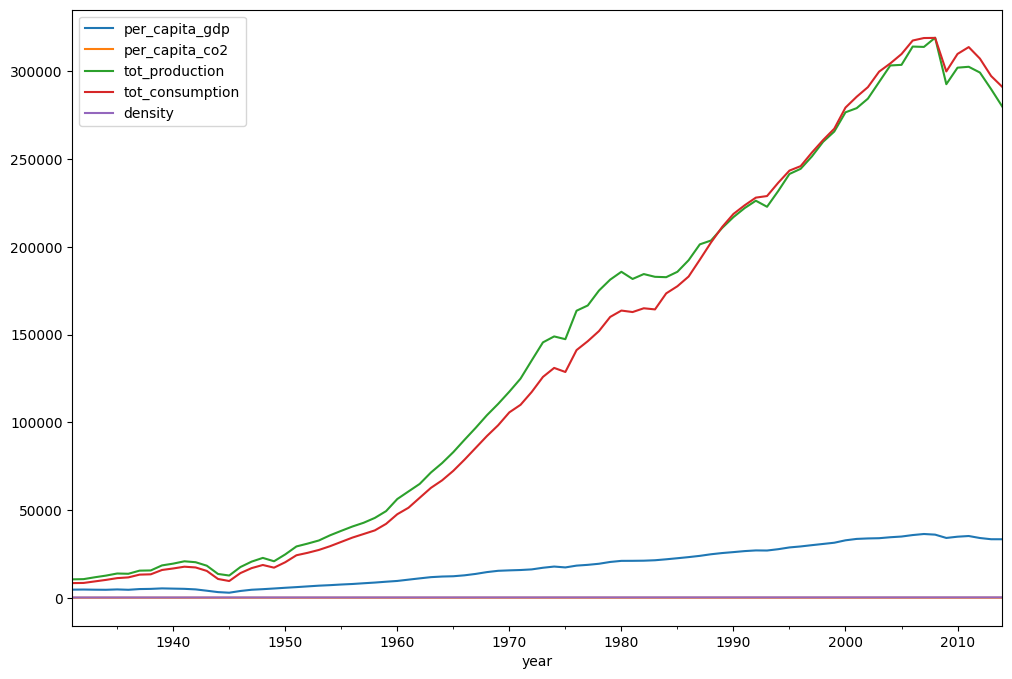

In [812]:
data[['per_capita_gdp','per_capita_co2','tot_production','tot_consumption','density']].plot(figsize=(12,8))

<Axes: xlabel='year'>

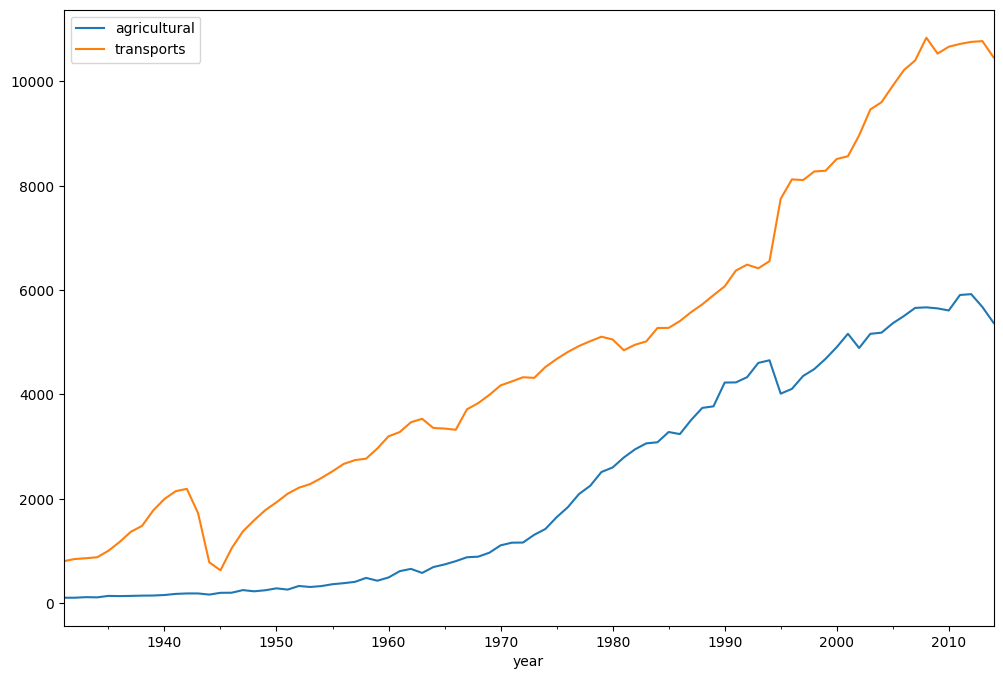

In [813]:
data[['agricultural','transports']].plot(figsize=(12,8))

In [814]:
prod_cycle,prod_trend = hpfilter(data['tot_production'])

<Axes: xlabel='year'>

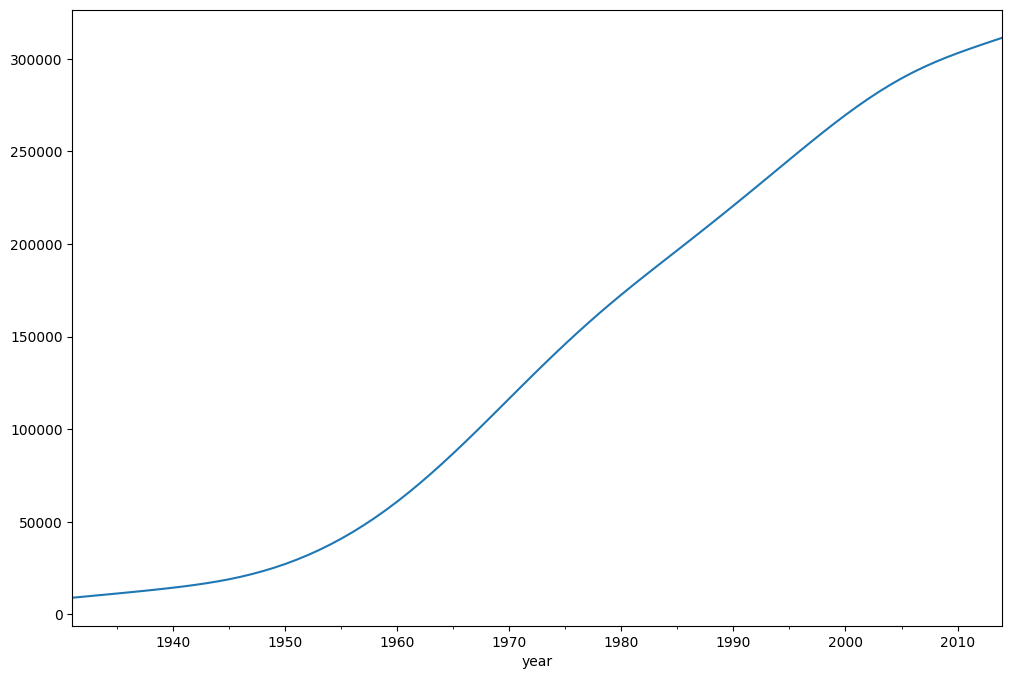

In [815]:
prod_trend.plot(figsize=(12,8))

In [816]:
data['production_trend'] = prod_trend

<Axes: xlabel='year'>

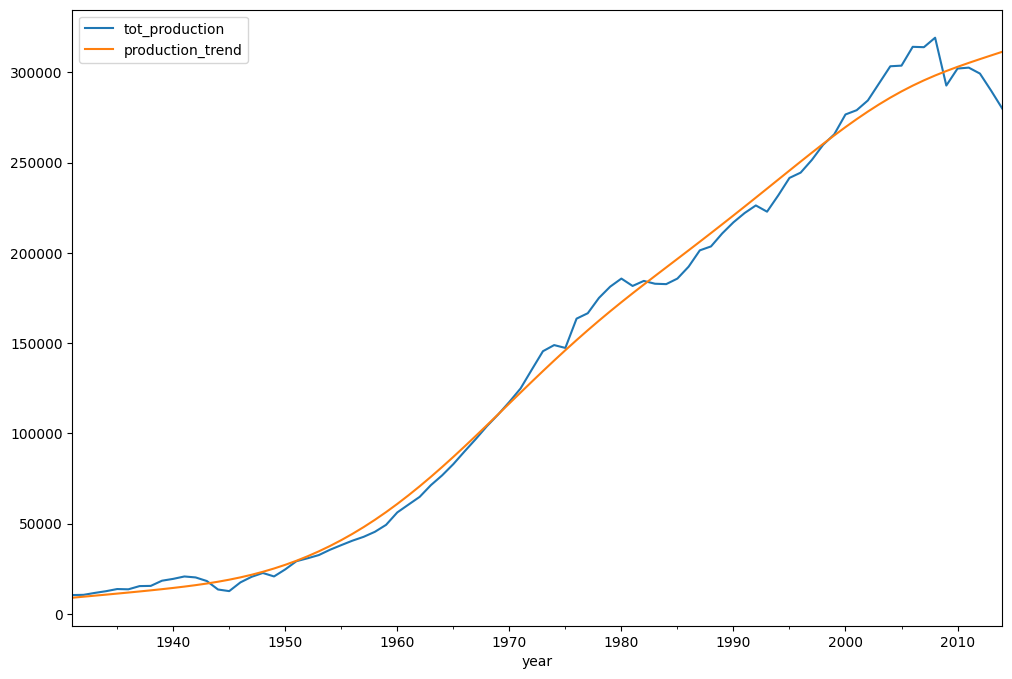

In [817]:
data[['tot_production','production_trend']].plot(figsize=(12,8))

In [818]:
cons_cycle,cons_trend = hpfilter(data['tot_consumption'])

In [819]:
data['consumption_trend'] = cons_trend

<Axes: xlabel='year'>

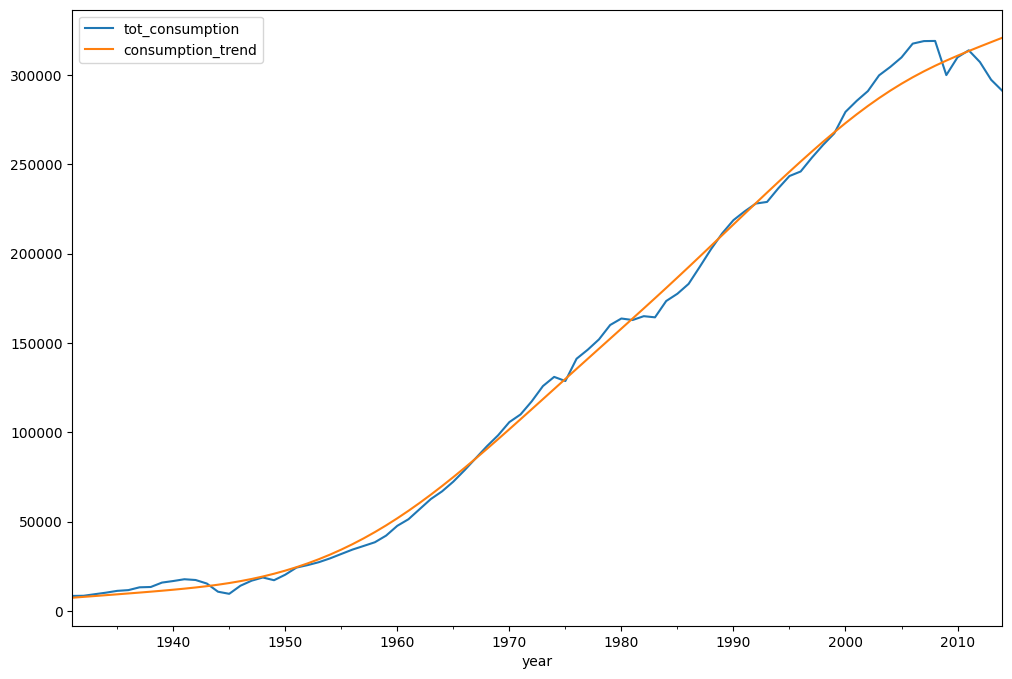

In [820]:
data[['tot_consumption','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

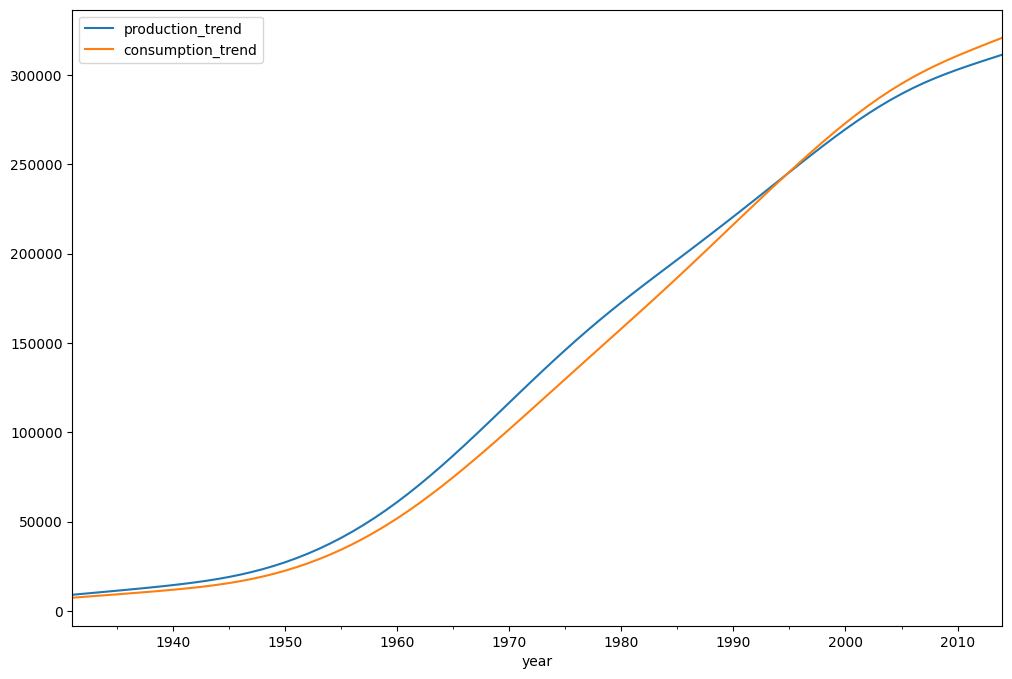

In [821]:
data[['production_trend','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

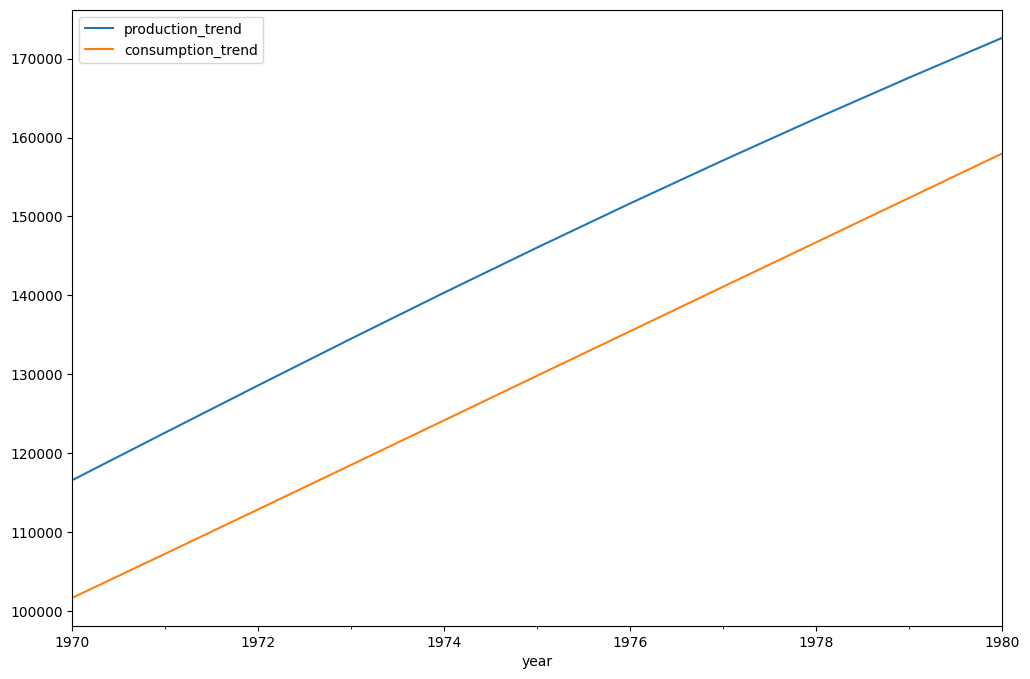

In [822]:
data[['production_trend','consumption_trend']].loc['1970-01-01':'1980-01-01'].plot(figsize=(12,8))

In [823]:
data['5-year-MA'] = data['tot_production'].rolling(window=5).mean()

In [824]:
data['10-year-MA'] = data['tot_production'].rolling(window=10).mean()

<Axes: xlabel='year'>

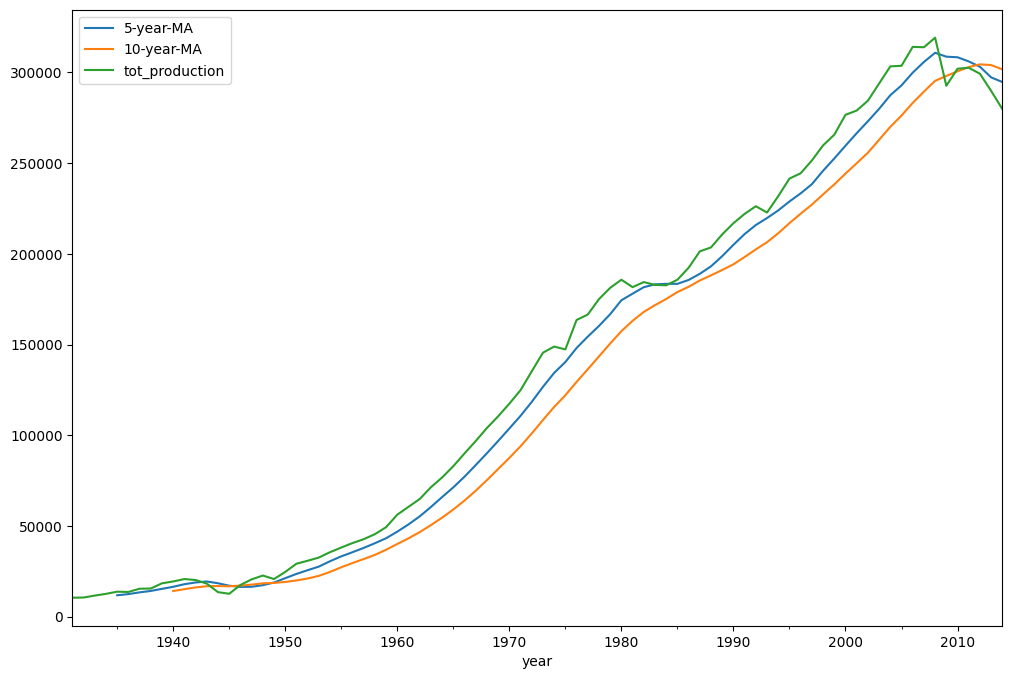

In [825]:
data[['5-year-MA','10-year-MA','tot_production']].plot(figsize=(12,8))

In [826]:
data.drop(['production_trend', 'consumption_trend','5-year-MA', '10-year-MA'],axis=1,inplace=True)

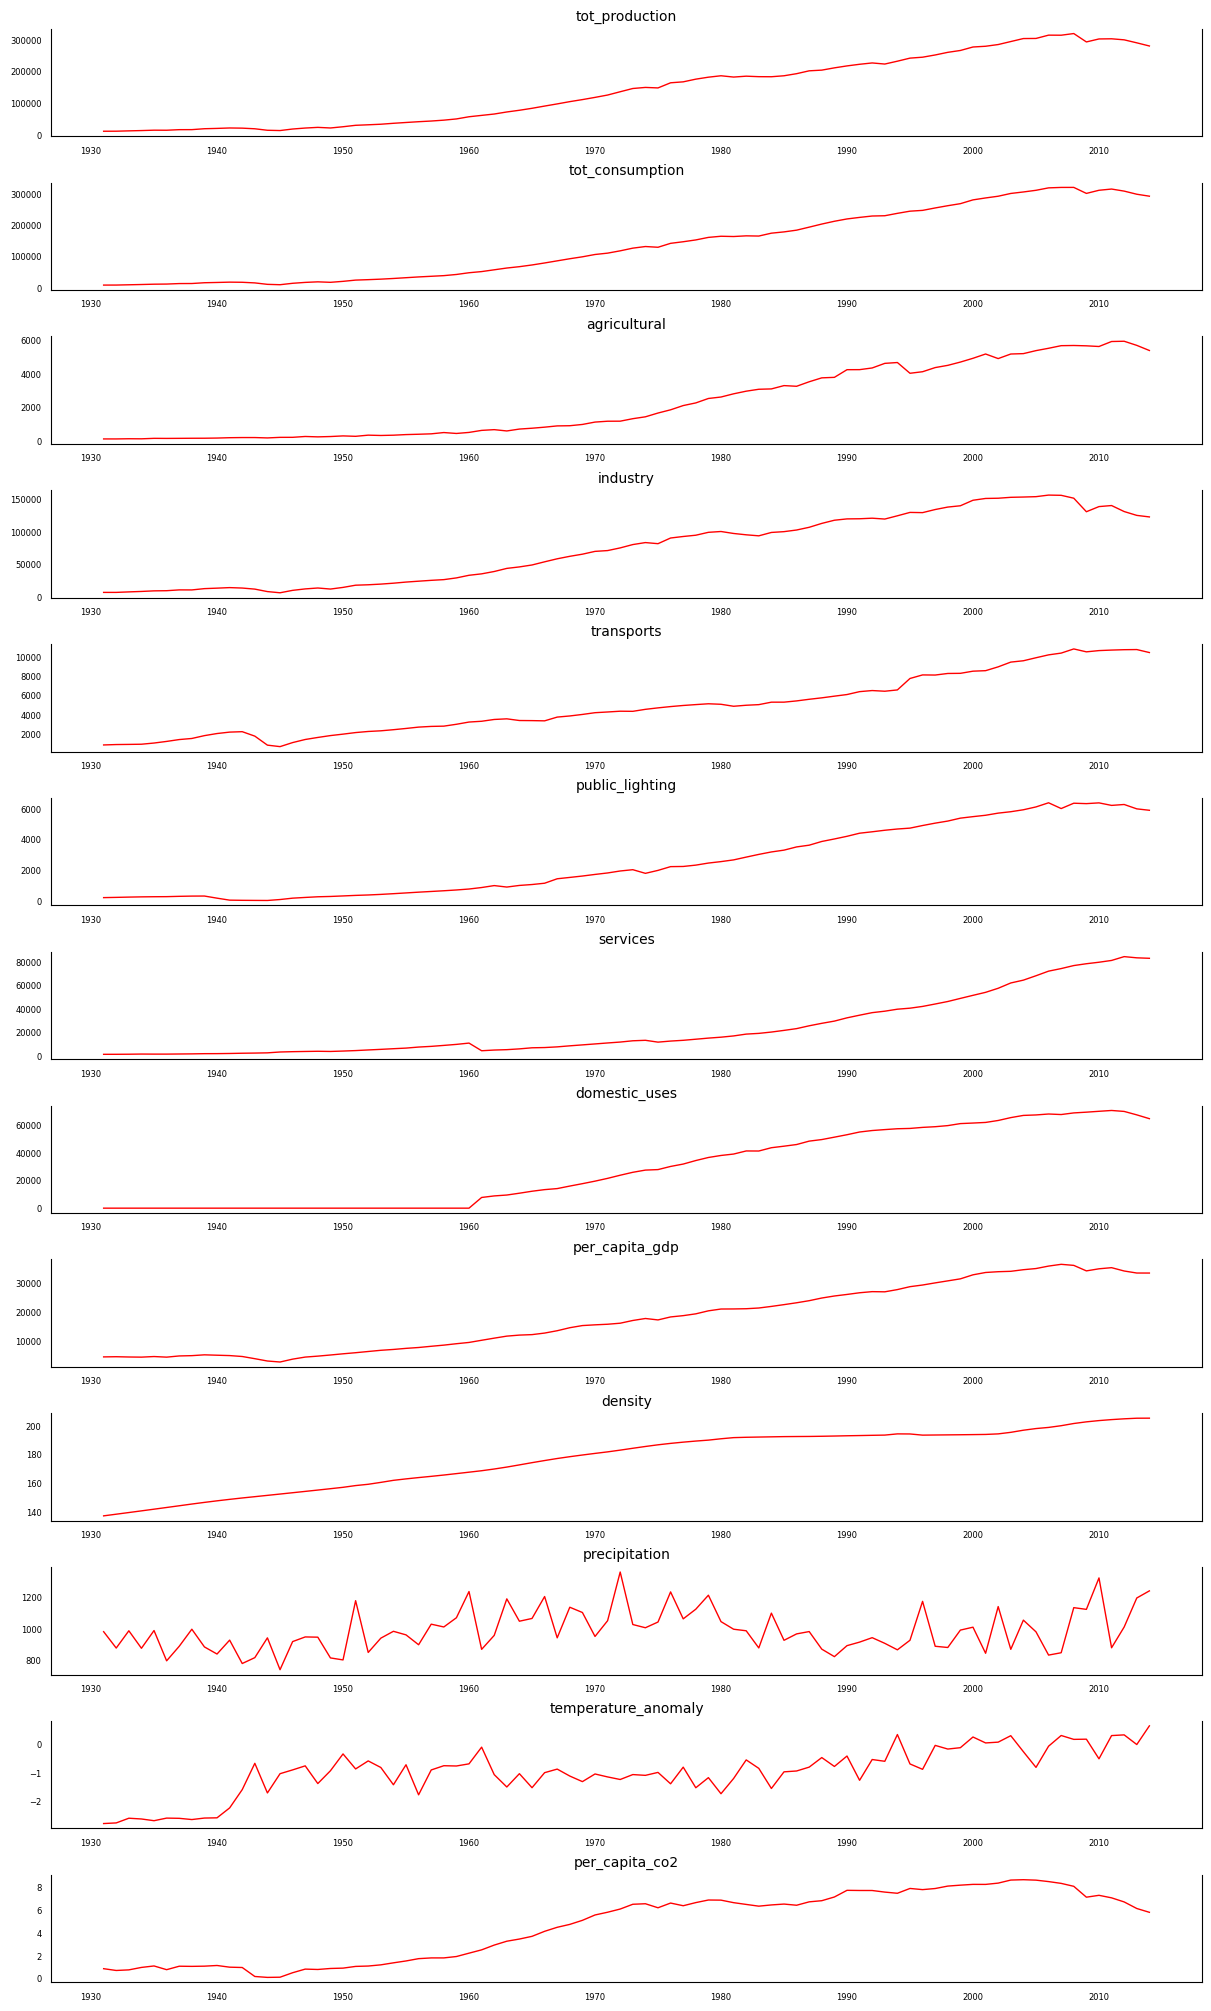

In [827]:
fig, axes = plt.subplots(nrows=data.shape[1],figsize=(12, 20),constrained_layout=True)

for i, ax in enumerate(axes):
    data_ = data[data.columns[i]]
    
    ax.plot(data_, color='red', linewidth=1)
    ax.set_title(data.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.show()

In [828]:
result = seasonal_decompose(data['tot_production'])

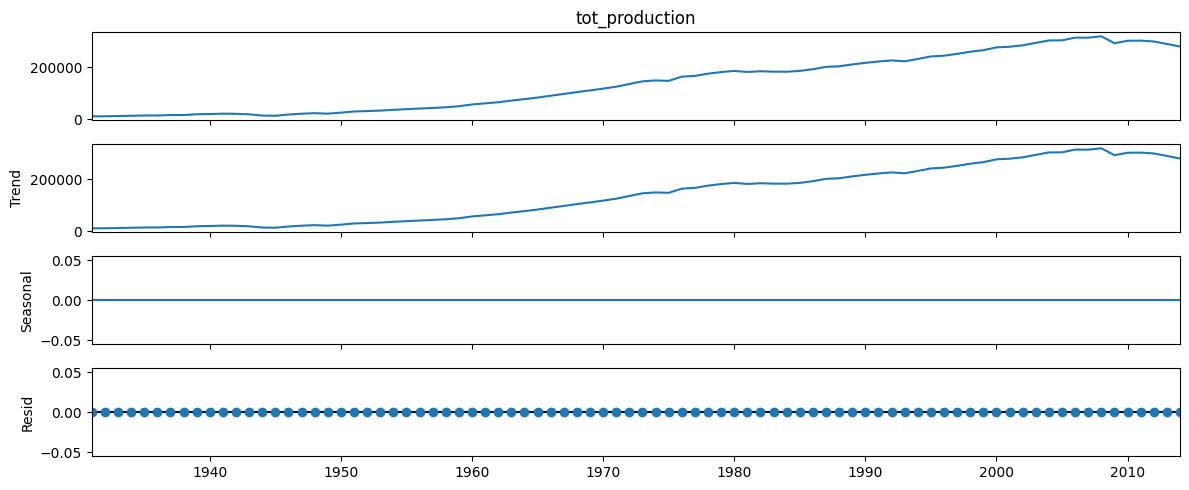

In [829]:
rcParams['figure.figsize'] = 12,5
result.plot();

In [830]:
result = seasonal_decompose(data['tot_consumption'])

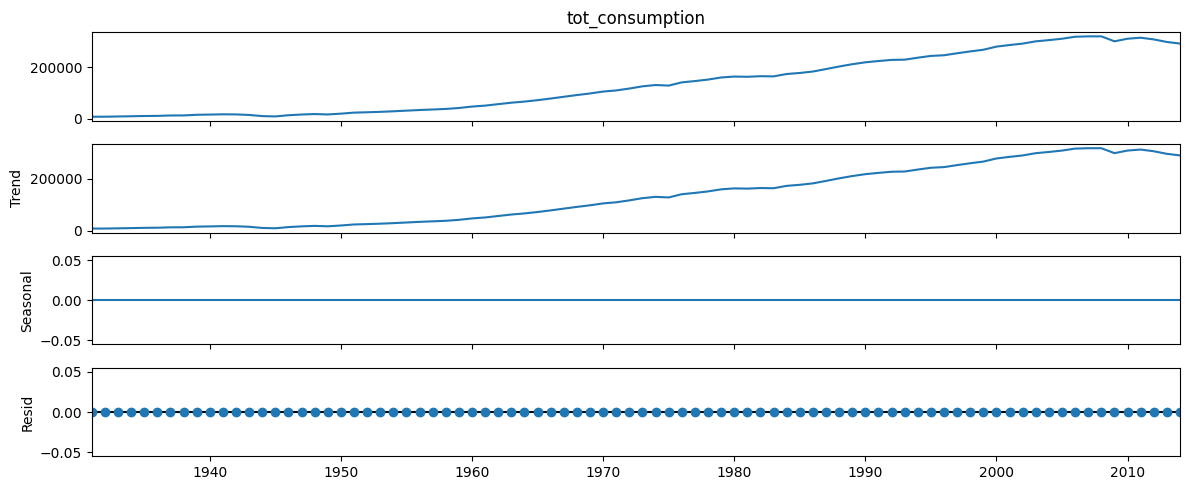

In [831]:
rcParams['figure.figsize'] = 12,5
result.plot();

## data for VAR model

In [832]:
data_owid_italy = data_owid[data_owid['country'] == 'Italy'].copy()

In [833]:
data_owid_italy

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
9949,Italy,1900,ITA,33332371.0,1.099054e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.112,1.170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.698,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9950,Italy,1901,ITA,33571430.0,1.123700e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.250,-0.132,30.940,1.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.693,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9951,Italy,1902,ITA,33827207.0,1.151736e+11,NaN,NaN,NaN,Na

In [834]:
data_owid_italy['year'] = pd.to_datetime(data_owid_italy['year'],format='%Y')

In [835]:
exclude_cols = ['electricity_demand','electricity_generation','net_elec_imports','carbon_intensity_elec','per_capita_electricity','electricity_demand_per_capita',
                'electricity_share_energy','net_elec_imports_share_demand']

cols = [col for col in data_owid_italy.columns if 'electricity' in col and col not in exclude_cols]

data_owid_electricity = pd.concat(
    [data_owid_italy[['year','population','gdp'] + exclude_cols],data_owid_italy[cols]],axis=1).set_index('year').dropna()

In [836]:
data_owid_share_elec = pd.concat(
     [data_owid_italy[['year','electricity_demand','electricity_generation']],
     data_owid_italy.filter(like='share_elec',axis=1)],axis=1).set_index('year').dropna()

In [837]:
data_owid_electricity = data_owid_electricity.merge(cpi,left_index=True,right_index=True,how='left')

In [838]:
data_owid_electricity.head() # electricity generation from xxx measured in terawatt-hours

,population,gdp,electricity_demand,electricity_generation,net_elec_imports,carbon_intensity_elec,per_capita_electricity,electricity_demand_per_capita,electricity_share_energy,net_elec_imports_share_demand,biofuel_electricity,coal_electricity,fossil_electricity,gas_electricity,hydro_electricity,low_carbon_electricity,nuclear_electricity,oil_electricity,other_renewable_electricity,other_renewable_exc_biofuel_electricity,renewables_electricity,solar_electricity,wind_electricity,cpi
year,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01,56756560.0,1.475485e+12,247.80,213.15,34.65,564.251,3755.513,4366.015,11.928,13.983,0.05,32.05,178.25,39.71,31.63,34.90,0.0,106.49,3.27,3.22,34.90,0.00,0.00,55.838990
1991-01-01,56794488.0,1.509176e+12,253.51,218.43,35.08,533.764,3845.972,4463.637,11.973,13.838,0.11,28.50,172.90,36.34,42.24,45.53,0.0,108.06,3.29,3.18,45.53,0.00,0.00,59.328926
1992-01-01,56833184.0,1.531924e+12,257.98,222.68,35.30,527.214,3918.133,4539.250,12.261,13.683,0.10,21.36,176.91,35.48,42.20,45.77,0.0,120.07,3.56,3.46,45.77,0.01,0.00,62.455914
1993-01-01,56869456.0,1.529550e+12,259.17,219.74,39.43,517.566,3863.937,4557.280,12.366,15.214,0.12,16.66,174.52,39.96,41.42,45.22,0.0,117.90,3.79,3.67,45.22,0.01,0.00,65.345580
1994-01-01,56883820.0,1.573415e+12,266.35,228.75,37.60,517.814,4021.354,4682.351,12.947,14.117,0.15,19.86,180.50,40.80,44.66,48.25,0.0,119.84,3.57,3.42,48.25,0.01,0.01,67.993280


In [839]:
data_owid_electricity.head()

,population,gdp,electricity_demand,electricity_generation,net_elec_imports,carbon_intensity_elec,per_capita_electricity,electricity_demand_per_capita,electricity_share_energy,net_elec_imports_share_demand,biofuel_electricity,coal_electricity,fossil_electricity,gas_electricity,hydro_electricity,low_carbon_electricity,nuclear_electricity,oil_electricity,other_renewable_electricity,other_renewable_exc_biofuel_electricity,renewables_electricity,solar_electricity,wind_electricity,cpi
year,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01,56756560.0,1.475485e+12,247.80,213.15,34.65,564.251,3755.513,4366.015,11.928,13.983,0.05,32.05,178.25,39.71,31.63,34.90,0.0,106.49,3.27,3.22,34.90,0.00,0.00,55.838990
1991-01-01,56794488.0,1.509176e+12,253.51,218.43,35.08,533.764,3845.972,4463.637,11.973,13.838,0.11,28.50,172.90,36.34,42.24,45.53,0.0,108.06,3.29,3.18,45.53,0.00,0.00,59.328926
1992-01-01,56833184.0,1.531924e+12,257.98,222.68,35.30,527.214,3918.133,4539.250,12.261,13.683,0.10,21.36,176.91,35.48,42.20,45.77,0.0,120.07,3.56,3.46,45.77,0.01,0.00,62.455914
1993-01-01,56869456.0,1.529550e+12,259.17,219.74,39.43,517.566,3863.937,4557.280,12.366,15.214,0.12,16.66,174.52,39.96,41.42,45.22,0.0,117.90,3.79,3.67,45.22,0.01,0.00,65.345580
1994-01-01,56883820.0,1.573415e+12,266.35,228.75,37.60,517.814,4021.354,4682.351,12.947,14.117,0.15,19.86,180.50,40.80,44.66,48.25,0.0,119.84,3.57,3.42,48.25,0.01,0.01,67.993280


In [840]:
data_owid_share_elec.head() # share of electricity generated by xxx measured as a percentage of total electricity

,electricity_demand,electricity_generation,biofuel_share_elec,coal_share_elec,fossil_share_elec,gas_share_elec,hydro_share_elec,low_carbon_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_share_elec,solar_share_elec,wind_share_elec
year,,,,,,,,,,,,,,,
1990-01-01,247.80,213.15,0.023,15.036,83.627,18.630,14.839,16.373,0.0,49.960,1.534,1.511,16.373,0.000,0.000
1991-01-01,253.51,218.43,0.050,13.048,79.156,16.637,19.338,20.844,0.0,49.471,1.506,1.456,20.844,0.000,0.000
1992-01-01,257.98,222.68,0.045,9.592,79.446,15.933,18.951,20.554,0.0,53.920,1.599,1.554,20.554,0.004,0.000
1993-01-01,259.17,219.74,0.055,7.582,79.421,18.185,18.850,20.579,0.0,53.654,1.725,1.670,20.579,0.005,0.000
1994-01-01,266.35,228.75,0.066,8.682,78.907,17.836,19.523,21.093,0.0,52.389,1.561,1.495,21.093,0.004,0.004


<Axes: xlabel='year'>

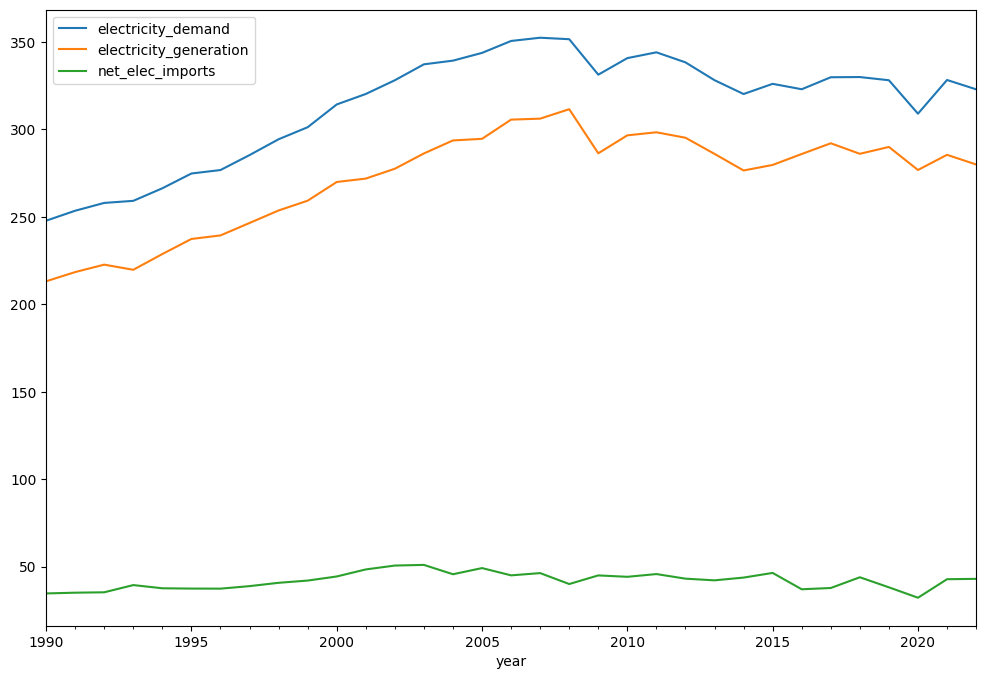

In [841]:
data_owid_electricity[['electricity_demand','electricity_generation','net_elec_imports']].plot(figsize=(12,8))

<Axes: xlabel='year'>

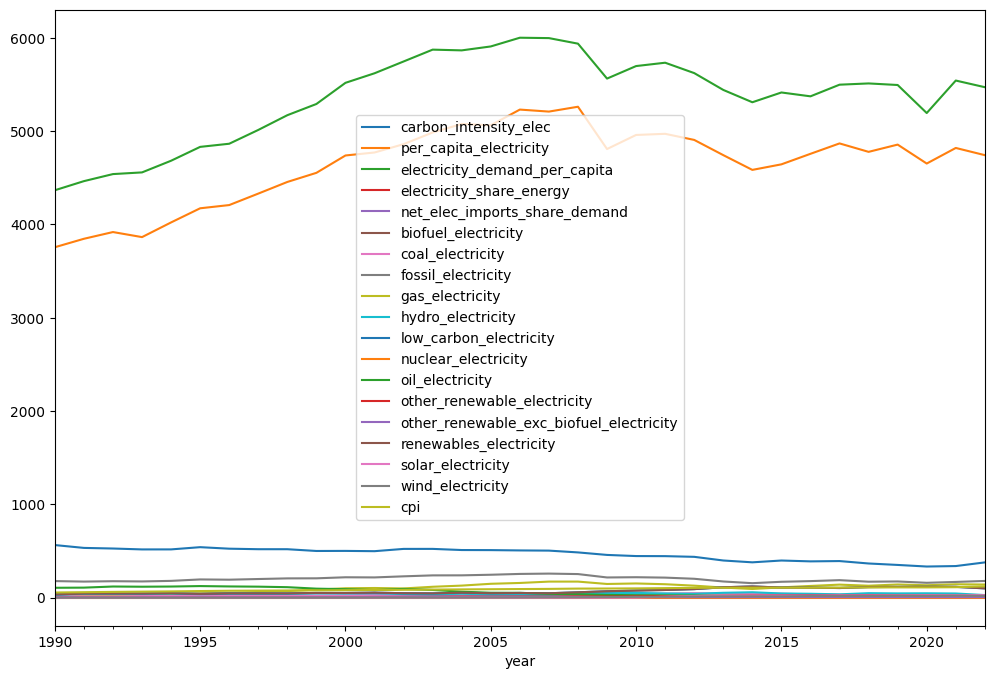

In [842]:
data_owid_electricity.drop(['population','gdp','electricity_demand','electricity_generation','net_elec_imports'],axis=1).plot(figsize=(12,8))

<Axes: xlabel='year'>

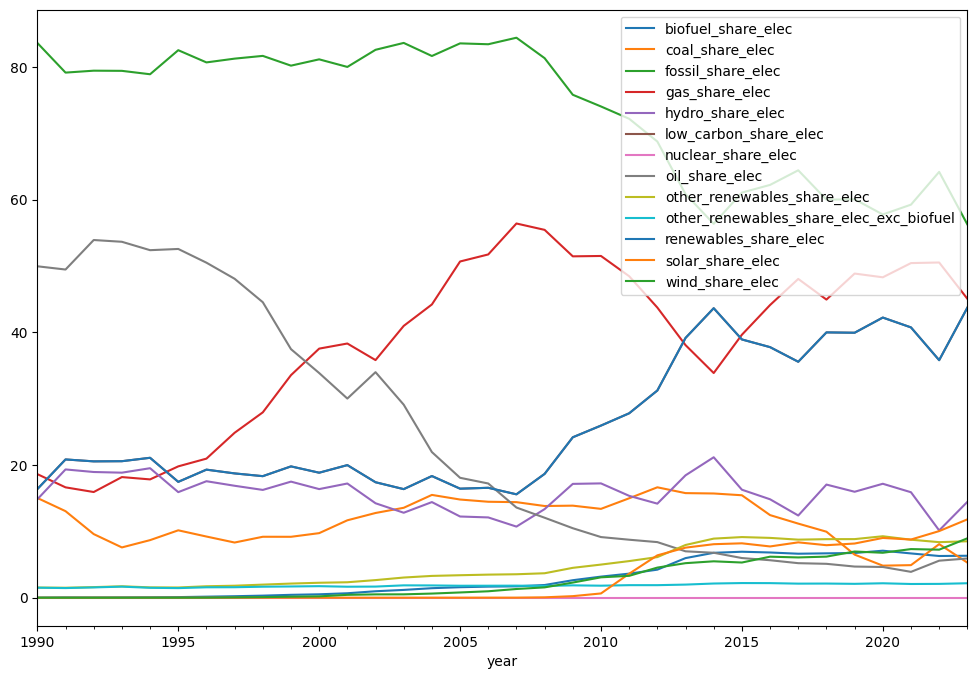

In [843]:
data_owid_share_elec.drop(['electricity_demand','electricity_generation'],axis=1).plot(figsize=(12,8))

In [844]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['gdp'] / data_owid_electricity['population']

In [845]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['per_capita_gdp'] / 100

## var model dataset

In [846]:
data.head()

,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,per_capita_gdp,density,precipitation,temperature_anomaly,per_capita_co2
year,,,,,,,,,,,,,
1931-01-01,10470,8335,103,6213,803,209,1007,0,4608.685542,136.95912,980.4897,-2.784570,0.843747
1932-01-01,10590,8420,103,6223,845,225,1024,0,4668.223864,138.11601,876.2479,-2.762485,0.687129
1933-01-01,11650,9293,114,6984,860,243,1092,0,4576.197903,139.27339,986.2547,-2.598746,0.739915
1934-01-01,12600,10159,110,7684,879,258,1228,0,4526.474142,140.44048,874.7829,-2.625348,0.954982
1935-01-01,13800,11168,138,8583,1003,267,1177,0,4731.370802,141.61732,987.7974,-2.685322,1.083517


In [847]:
data.columns

Index(['tot_production', 'tot_consumption', 'agricultural', 'industry',
       'transports', 'public_lighting', 'services', 'domestic_uses',
       'per_capita_gdp', 'density', 'precipitation', 'temperature_anomaly',
       'per_capita_co2'],
      dtype='object')

In [ ]:
var_data = data[['density','precipitation','temperature_anomaly','per_capita_co2','tot_production']]

In [849]:
correlation_matrix = var_data.corr()
print(correlation_matrix)

                      density  precipitation  temperature_anomaly  \
density              1.000000       0.319000             0.744804   
precipitation        0.319000       1.000000             0.083646   
temperature_anomaly  0.744804       0.083646             1.000000   
per_capita_co2       0.944933       0.242768             0.608703   
tot_production       0.940912       0.213933             0.708209   

                     per_capita_co2  tot_production  
density                    0.944933        0.940912  
precipitation              0.242768        0.213933  
temperature_anomaly        0.608703        0.708209  
per_capita_co2             1.000000        0.948256  
tot_production             0.948256        1.000000  


<Axes: xlabel='year'>

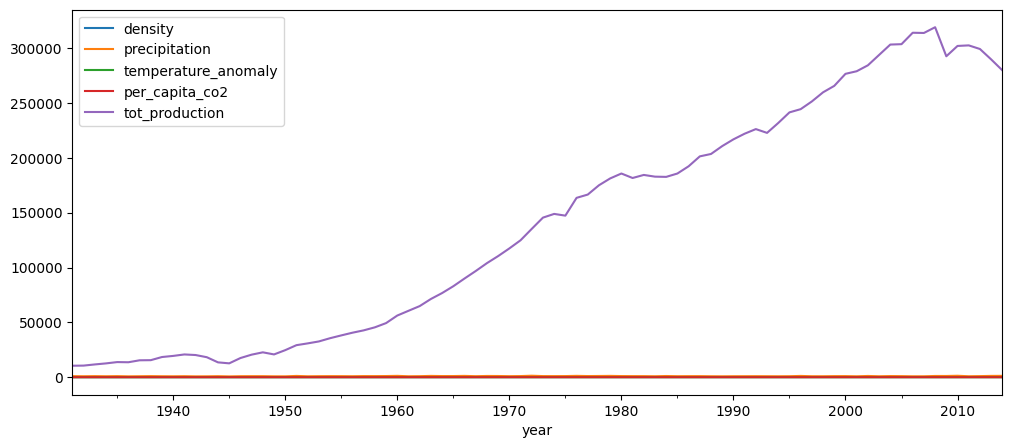

In [850]:
var_data.plot()

# var model

## stationarity test

In [851]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())         
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

In [852]:
adf_results = {}
for var in var_data.columns:
    print('-----------------------------------------------------------------')
    adf_results[var] = adf_test(var_data[var],title=var)

-----------------------------------------------------------------
Augmented Dickey-Fuller Test: density
ADF test statistic      -2.107708
p-value                  0.241427
# lags used              6.000000
# observations          77.000000
critical value (1%)     -3.518281
critical value (5%)     -2.899878
critical value (10%)    -2.587223
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
-----------------------------------------------------------------
Augmented Dickey-Fuller Test: precipitation
ADF test statistic      -2.212645
p-value                  0.201688
# lags used             10.000000
# observations          73.000000
critical value (1%)     -3.523284
critical value (5%)     -2.902031
critical value (10%)    -2.588371
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
-----------------------------------------------------------------
Augm

In [853]:
for var,result in adf_results.items():
    print(f"{var}: p-value = {result['p-value']}")

density: p-value = 0.24142654833871208
precipitation: p-value = 0.20168792538691344
temperature_anomaly: p-value = 0.4277772390133839
per_capita_co2: p-value = 0.5894144616935306
tot_production: p-value = 0.6054685093948645


In [854]:
def adf_test_(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # return only the p-value

stationary_data = var_data.copy()
diff_count = {col: 0 for col in stationary_data.columns}

# Loop through each column
for col in stationary_data.columns:
    pval = adf_test_(stationary_data[col])
    
    # Keep differencing until the series becomes stationary
    while pval > 0.05:
        stationary_data[col] = stationary_data[col].diff()
        diff_count[col] += 1
        pval = adf_test_(stationary_data[col])

        print(f"{col}: differenced {diff_count[col]} time(s), p-value = {pval:.4f}")

stationary_data = stationary_data.dropna()

print("\nNumber of differences applied per variable:")
print(pd.Series(diff_count))

print("\nStationary DataFrame ready for VAR model:")
print(stationary_data.head())

density: differenced 1 time(s), p-value = 0.2120


density: differenced 2 time(s), p-value = 0.0085
precipitation: differenced 1 time(s), p-value = 0.5506
precipitation: differenced 2 time(s), p-value = 0.0000
temperature_anomaly: differenced 1 time(s), p-value = 0.0000
per_capita_co2: differenced 1 time(s), p-value = 0.0040
tot_production: differenced 1 time(s), p-value = 0.5047
tot_production: differenced 2 time(s), p-value = 0.0000

Number of differences applied per variable:
density                2
precipitation          2
temperature_anomaly    1
per_capita_co2         1
tot_production         2
dtype: int64

Stationary DataFrame ready for VAR model:
            density  precipitation  temperature_anomaly  per_capita_co2  \
year                                                                      
1933-01-01  0.00049       214.2486             0.163739        0.052786   
1934-01-01  0.00971      -221.4786            -0.026602        0.215066   
1935-01-01  0.00975       224.4863            -0.059974        0.128536   
1936-01-01 

In [855]:
stationary_data.head()

,density,precipitation,temperature_anomaly,per_capita_co2,tot_production
year,,,,,
1933-01-01,0.00049,214.2486,0.163739,0.052786,940.0
1934-01-01,0.00971,-221.4786,-0.026602,0.215066,-110.0
1935-01-01,0.00975,224.4863,-0.059974,0.128536,250.0
1936-01-01,0.00989,-305.9370,0.090599,-0.326001,-1352.0
1937-01-01,0.00992,285.6835,-0.007782,0.303322,1934.0


In [856]:
adf_results = {}
for var in stationary_data.columns:
    print('-----------------------------------------------------------------')
    adf_results[var] = adf_test(stationary_data[var],title=var)

-----------------------------------------------------------------
Augmented Dickey-Fuller Test: density
ADF test statistic      -3.479462
p-value                  0.008530
# lags used              7.000000
# observations          74.000000
critical value (1%)     -3.521980
critical value (5%)     -2.901470
critical value (10%)    -2.588072
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
-----------------------------------------------------------------
Augmented Dickey-Fuller Test: precipitation
ADF test statistic     -8.086934e+00
p-value                 1.411613e-12
# lags used             8.000000e+00
# observations          7.300000e+01
critical value (1%)    -3.523284e+00
critical value (5%)    -2.902031e+00
critical value (10%)   -2.588371e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
-----------------------------------------------------------------
A

## var model

In [857]:
model = VAR(stationary_data)
for i in [1,2,3,4,5,6,7,8,9,10]:
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  20.782954189946622
BIC:  21.669787210195675

Order = 2
AIC:  20.2257679442941
BIC:  21.863411255632393

Order = 3
AIC:  20.047768393515945
BIC:  22.44720925677369

Order = 4
AIC:  20.202122415612003
BIC:  23.374615066924914

Order = 5
AIC:  19.923019844862015
BIC:  23.880093933705894

Order = 6
AIC:  20.040651046060514
BIC:  24.794120358486584

Order = 7
AIC:  20.3203356164123
BIC:  25.882307088899445

Order = 8
AIC:  19.669302172433124
BIC:  26.052185200904134

Order = 9
AIC:  19.620142427772304
BIC:  26.836658475226137

Order = 10
AIC:  19.110865520485532
BIC:  27.174058025334062



In [858]:
result = model.fit(2)

In [859]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Apr, 2025
Time:                     22:51:11
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    21.8634
Nobs:                     80.0000    HQIC:                   20.8823
Log likelihood:          -1321.61    FPE:                6.13403e+08
AIC:                      20.2258    Det(Omega_mle):     3.22099e+08
--------------------------------------------------------------------
Results for equation density
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -0.050391         0.030919           -1.630           0.103
L1.density                    -0.036342         0.111243           -0.327           0.744
L1.precipitation      

In [860]:
lag_order = results.k_ar
lag_order

10

In [861]:
z = results.forecast(y=stationary_data.values[-lag_order:],steps=5)
z

array([[-1.94391805e-01, -4.02065217e+02, -7.21124878e-01,
         1.91439201e+00,  5.44014981e+04],
       [-3.23638820e-01,  7.21173752e+02,  2.15213916e+00,
        -3.87994506e-01, -5.10742496e+04],
       [ 1.50739785e+00, -1.11840740e+02, -1.93829069e+00,
         5.00237818e-02, -7.82995057e+03],
       [ 1.12900679e+00, -3.56587762e+02,  2.08637409e+00,
        -3.23327600e-01,  3.92721581e+03],
       [-7.52787861e-01, -6.69150806e+02, -1.73215352e+00,
         1.01807892e+00,  2.38719556e+04]])

In [862]:
idx = pd.date_range('2015-01-01',periods=5, freq='YS')

In [863]:
df_forecast = pd.DataFrame(z, index=idx)

In [864]:
df_forecast

,0,1,2,3,4
2015-01-01,-0.194392,-402.065217,-0.721125,1.914392,54401.498060
2016-01-01,-0.323639,721.173752,2.152139,-0.387995,-51074.249611
2017-01-01,1.507398,-111.840740,-1.938291,0.050024,-7829.950571
2018-01-01,1.129007,-356.587762,2.086374,-0.323328,3927.215812
2019-01-01,-0.752788,-669.150806,-1.732154,1.018079,23871.955556


<Axes: >

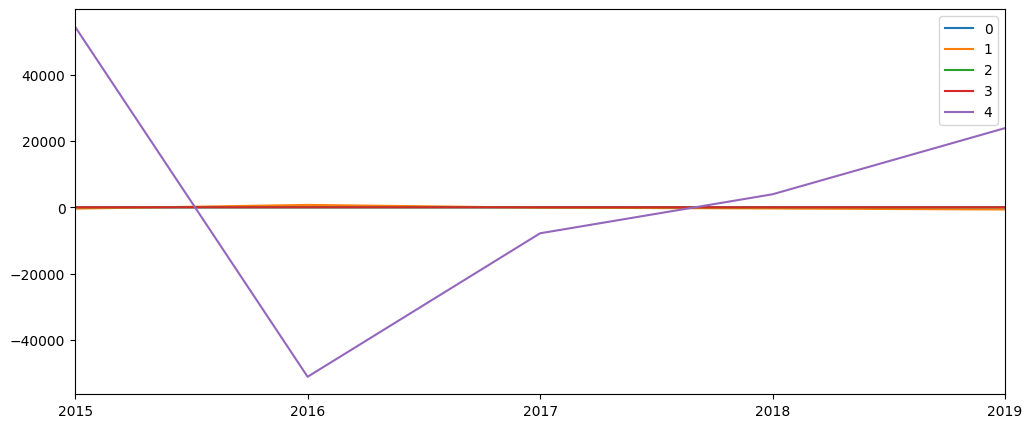

In [865]:
df_forecast.plot()